In [40]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange
from numpy.random import normal
from scipy.stats import norm
from tqdm import tqdm

In [61]:
@njit
def euler_Method(S0, interest_rate, delta_t, N, volatility):
    prev_S = S0
    stock_prices = np.empty(N)
    stock_prices[0] = S0
    for i in range(1, N):  # Use prange for parallel execution
        Zm = normal()
        next_S = prev_S * (1 + interest_rate * delta_t + volatility * np.sqrt(delta_t) * Zm)
        prev_S = next_S
        stock_prices[i] = next_S
    return stock_prices

In [44]:

def euler_Method(S0, interest_rate, delta_t, N, volatality):
    """
    Euler method for stock price simulation 

    Args:
        S0 : Stock price at time 0
        interest_rate : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        volatality : Volatality of the stock

    Returns:
        stock_prices : Stock prices for N time steps
    """
    prev_S = S0
    stock_prices = np.zeros(N)
    stock_prices[0] = prev_S
    for i in range(1, N):
        Zm = norm.rvs()
        next_S = prev_S * ( 1 + interest_rate * delta_t + volatality * np.sqrt(delta_t) * Zm )
        prev_S = next_S
        stock_prices[i] = next_S
    return stock_prices

In [48]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality):
    
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    option_price =  - current_stock_price * norm.cdf(-d1) + np.exp(-interest_rate * tao) * strike_price * norm.cdf(-d2)
    
    return option_price

In [49]:
# Parameters
T = 1.0
K = 99
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 1/252
N = int(T/delta_t)
# Option price from black scholes
option_BS = blackScholes(S0, K, 0, T, r, sigma)

In [62]:
@njit

def priceOption(S0, r, delta_t, N, sigma, K, M, option_type):
    """
    Function to price the option using Monte Carlo simulation  
    Args:
        S0 : Initial stock price
        r : Risk-free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatility of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option ('call' or 'put')
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    
    # Calculate price option and standard error
    price_option = np.exp(-r*T) * np.mean(pay_offs)
    std_error = np.std(pay_offs) / np.sqrt(M)
    
  
    m, sd = np.mean(pay_offs * np.exp(-r*T)), np.std(pay_offs * np.exp(-r*T))
    h = 1.96 * sd / np.sqrt(M) # Confidence interval calculation
    ml, mu = m - h, m + h # Lower and upper bounds
    
    return price_option, std_error, ml, mu

In [45]:
def priceOption(S0, r, delta_t, N, sigma, K, M, option_type):
    """
    Function to price the option using Monte Carlo simulation  
    Args:
        S0 : Stock price at time 0
        r : Risk free interest rate
        delta_t : Time step
        N : Number of time steps
        sigma : Volatality of the stock
        K : Strike price
        M : Number of simulations
        option_type : Type of option (call/put)
    Returns:
        price_option : Price of the option
        std_error : Standard error
        ml : Lower bound of the confidence interval 
        mu : Upper bound of the confidence interval
    """
    
    pay_offs = np.zeros(M)
    T  = N * delta_t
    for i in range(M):
        stock_price_N = (euler_Method(S0, r, delta_t, N, sigma))[-1]
        if option_type == "call":
            pay_off  = max(stock_price_N - K, 0)
        else:
            pay_off = max(K - stock_price_N, 0)
        pay_offs[i] = pay_off
    ml, mu = confidence_interval(pay_offs * np.exp(-r*T))
     a = data.shape[0]
    m, sd = np.mean(data), np.std(data)
    h = 1.96*sd/np.sqrt(a)
    return m - h, m + h

In [54]:
def confidence_interval(data):
        """
        Function to calculate confidence interval

        Args:
            data: Data for which confidence interval is to be calculated

        Returns:
                m-h, m+h : Lower and upper bounds of the confidence interval
        """
        a = data.shape[0]
        m, sd = np.mean(data), np.std(data)
        h = 1.96*sd/np.sqrt(a)
        return m - h, m + h

In [65]:
m = np.arange(100, 10000, 100)
option_values = []
std_errors = []
lower = []
upper = []
# Monte Carlo Simulation for option pricing
for M in tqdm(m):
    option_value, sd_error , ml, mu   = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    option_values.append(option_value)
    std_errors.append(sd_error)
    lower.append(ml)
    upper.append(mu)
print(option_values[-1])

100%|██████████| 99/99 [00:01<00:00, 58.20it/s] 

4.796638373080033


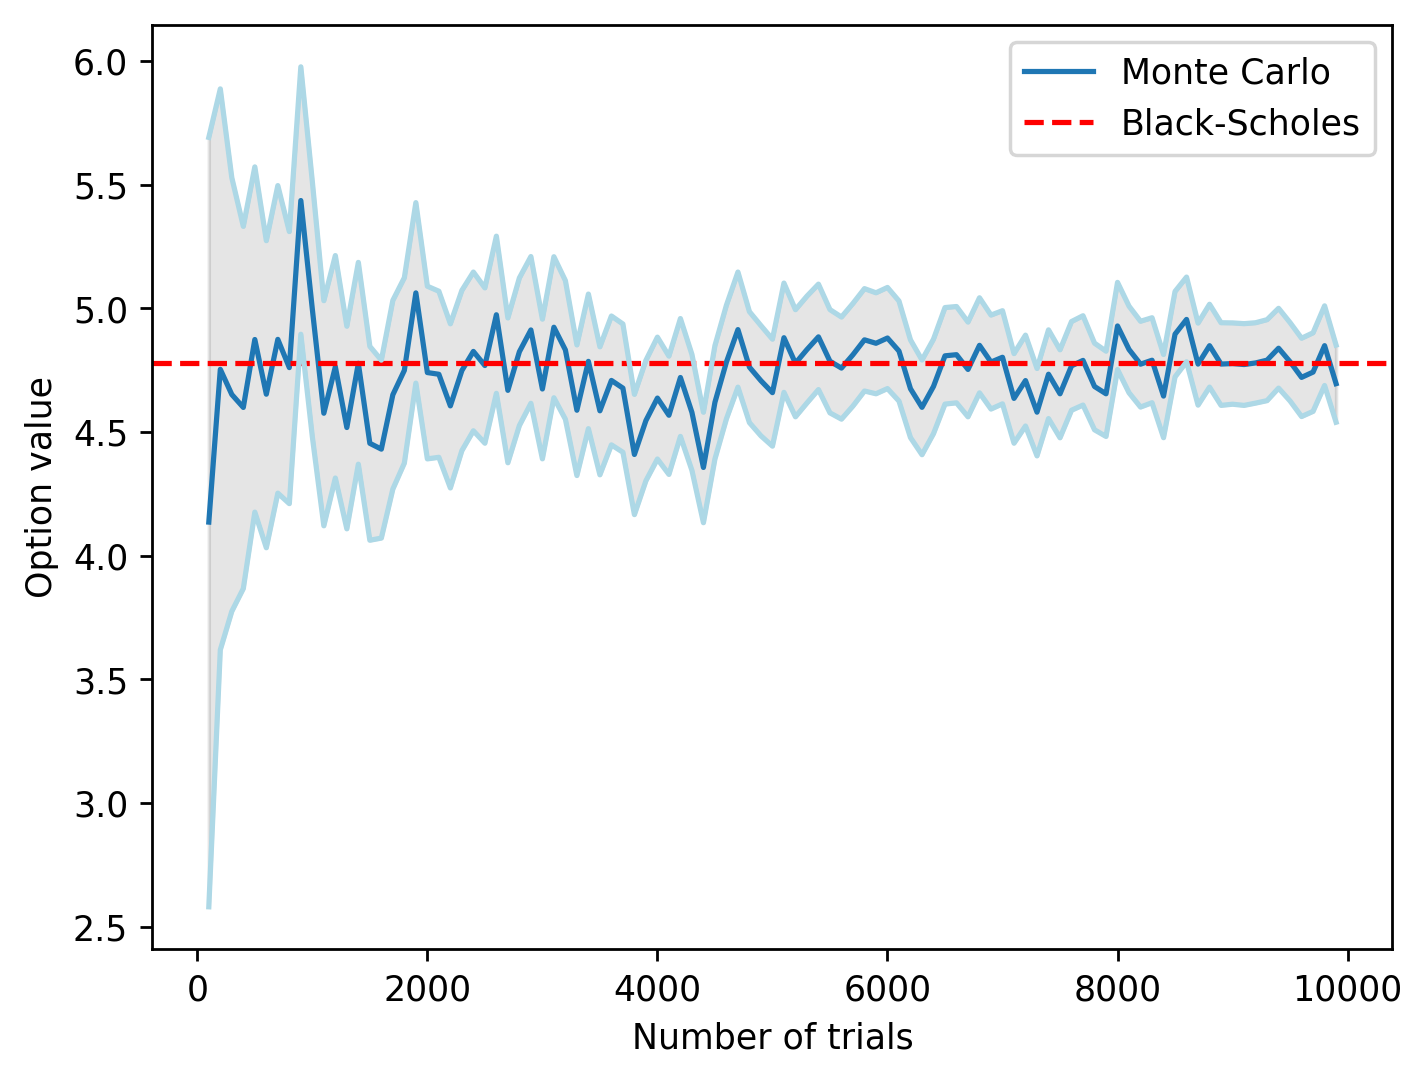

In [50]:
plt.figure(dpi=250)
plt.plot(m, option_values, label='Monte Carlo')
plt.axhline(option_BS, linestyle = "--", color = "red", label="Black-Scholes")
plt.plot(m, upper,color = "lightblue")
plt.plot(m, lower, color = "lightblue")
plt.fill_between(m, upper, lower, color="k", alpha=0.1)
plt.xlabel("Number of trials")
plt.ylabel("Option value")
plt.legend()
plt.show()

In [51]:
m = []
option_values = []
for M in np.arange(100, 10000, 50):
    option_value = priceOption(S0, r, delta_t, N, sigma, K, M,"put")
    m.append(M)
    option_values.append(option_value)

KeyboardInterrupt: 

Text(0, 0.5, 'Option value')

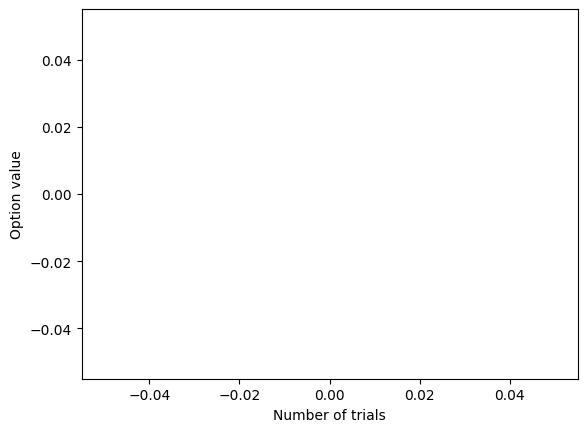

In [33]:
plt.plot(m, option_values)
plt.xlabel("Number of trials")
plt.ylabel("Option value")

In [25]:
## Varying strike price
K = np.arange(80, 120,2)
#volatality = 0.2
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 5000
N = int(T/delta_t)
option_values = []
for k in K:
    option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
    m.append(M)
    option_values.append(option_value)

Text(0, 0.5, 'Option Value')

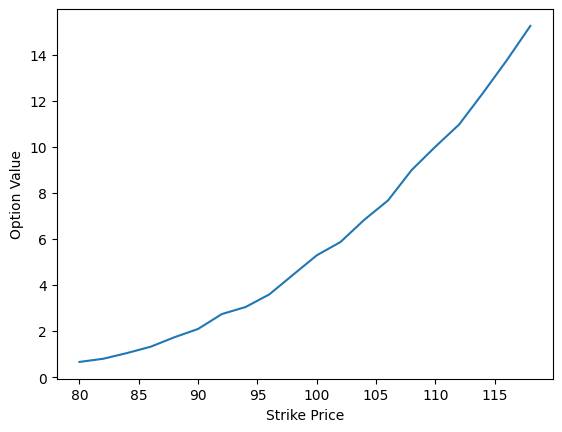

In [8]:
##Plotting the option values
plt.plot(K, option_values)
plt.xlabel("Strike Price")
plt.ylabel("Option Value")

In [9]:
### Varying volatality
vols = np.arange(0.1, 0.5, 0.01)
K = 99
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 5000
N = int(T/delta_t)
option_values = []
for vol in vols:
    option_value = priceOption(S0, r, delta_t, N, vol, K, M, "call")
    m.append(M)
    option_values.append(option_value)

Text(0, 0.5, 'Option Value')

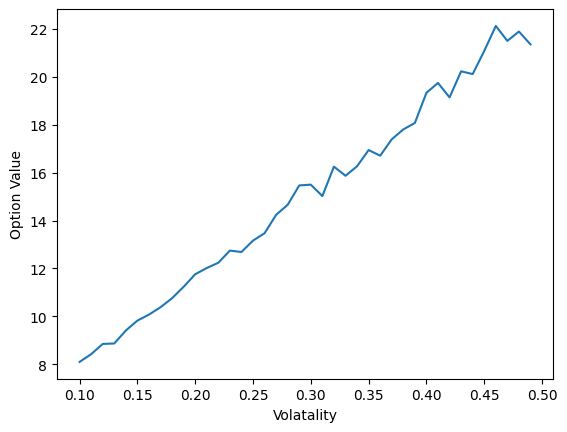

In [10]:
##Plotting the option values
plt.plot(vols, option_values)
plt.xlabel("Volatality")
plt.ylabel("Option Value")


# Part 2: Black Scholes

### Helper fuctions

In [11]:
def blackScholes(current_stock_price, strike_price, current_time, maturity_time, interest_rate, volatality):
    tao = maturity_time - current_time
    d1 = (np.log(current_stock_price/strike_price) + (interest_rate + volatality**2/2) * tao)/(volatality*np.sqrt(tao))
    d2 = d1 - volatality * np.sqrt(tao)
    option_price = current_stock_price * norm.cdf(d1) - np.exp(-interest_rate * tao) * strike_price * norm.cdf(d2)
    
    return option_price, norm.cdf(d1)

In [12]:
def calc_delta_bump(option_price_array, bumped_option_price_array, bump_size):
    option_price_array = np.array(option_price_array)
    bumped_option_price_array = np.array(bumped_option_price_array)
    delta_est = (option_price_array - bumped_option_price_array)/bump_size
    return delta_est


In [13]:
def digital_option_payoff(S0, K, type='call', position='long'):
    if type=='call':
        payoff = np.maximum(0, S0-K)
    elif type == 'put':
        payoff = np.maximum(0, K-S0)
    if position == 'long':
        return payoff
    elif position == 'short':
        return -1*payoff

In [14]:
# ## Varying strike price
# K = np.arange(80, 90,2)
# K = np.arange(80, 90,2)
# #volatality = 0.2
# T = 1.0
# r = 0.06
# S0 = 100 
# sigma = 0.2
# delta_t = 0.001
# M = 500
# N = int(T/delta_t)
# option_value_MC = []
# option_value_MC_bumped = []
# black_scholes_prices = []
# bumps = [0.1,0,5,1,5,10,20]
# # bumps = [0.1,0,5,1,5,10,20]

# # for bump in bumps:
#     for k in K:
#         option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "put")
#         option_bumped = priceOption(S0 + bump, r, delta_t, N, sigma, k, M, "put")
#         option_value_MC.append(option_value)
#         option_value_MC_bumped.append(option_bumped)
#         BS_option_price = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)
#         black_scholes_prices.append(BS_option_price)
#         black_scholes_delta.append
#         abs_error_ = np.



In [15]:
K = np.arange(80, 90,2)
T = 1.0
r = 0.06
S0 = 100 
K = 99
sigma = 0.2
delta_t = 0.001
M = 9000
N = int(T/delta_t)
bump = 0.5


option_value = priceOption(S0, r, delta_t, N, sigma, K, M, "call")
option_bumped = priceOption(S0 + bump, r, delta_t, N, sigma, K, M, "call")
delta_bump = (np.array(option_bumped) - np.array(option_value))/bump
BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[1]


print(f"Monte Carlo Delta: {delta_bump}")
print(f"Black-Scholes Delta: {BS_delta}")



C:\Users\nitai\AppData\Local\Temp\ipykernel_13040\2208368652.py:5: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "..\..\..\..\..\..\AppData\Local\Temp\ipykernel_13040\603230754.py", line 1:
<source missing, REPL/exec in use?>

  stock_price_N = euler_Method(S0, r, delta_t, N, sigma)[-1]


Monte Carlo Delta: 0.9550698649865907
Black-Scholes Delta: 0.6737355117348961


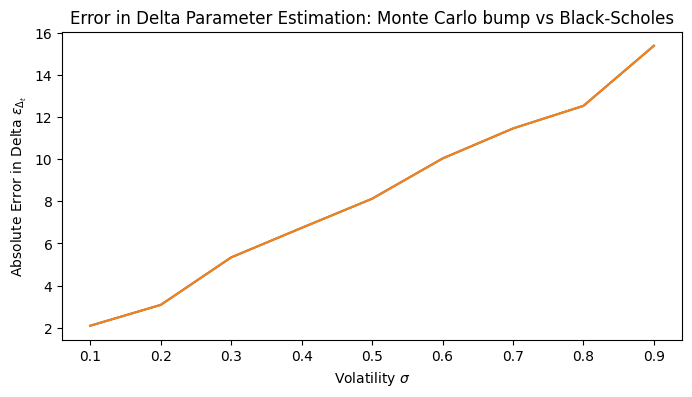

In [19]:

N = 50 
K = 99
r = 0.06
S0 = 100
T = 1
runs = 100
error_array = np.zeros((9,100))
plt.figure(figsize=(8, 4))
for index, run in enumerate(range(runs)):
    volatilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    deltas_binom = []
    deltas_BlackScholes = []
    errors = []

    for σ in volatilities:
        option_value = priceOption(S0, r, delta_t, N, σ, K, M, "call")
        option_bumped = priceOption(S0 + bump, r, delta_t, N, σ, K, M, "call")
        delta_MC_bump = (np.array(option_bumped) - np.array(option_value))/bump
        BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[1]
        deltas_BlackScholes.append(BS_delta)

        error = np.abs(BS_delta - delta_MC_bump)
        errors.append(error)

    # Plotting the errors with labels and title
    error_array[:,index] = errors

plt.plot(volatilities, np.mean(error_array, axis = 1))
plt.plot(volatilities, np.mean(error_array, axis = 1))

plt.title('Error in Delta Parameter Estimation: Monte Carlo bump vs Black-Scholes')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Absolute Error in Delta $\epsilon_{\Delta_{t}}$ ')
plt.show()

In [ ]:

N = 50 
K = 99
r = 0.06
S0 = 100
T = 1
runs = 100
error_array = np.zeros((9,100))
plt.figure(figsize=(8, 4))
for index, run in enumerate(range(runs)):
    volatilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    deltas_binom = []
    deltas_BlackScholes = []
    errors = []

    for σ in volatilities:
        option_value = priceOption(S0, r, delta_t, N, σ, K, M, "call")
        option_bumped = priceOption(S0 + bump, r, delta_t, N, σ, K, M, "call")
        delta_MC_bump = (np.array(option_bumped) - np.array(option_value))/bump
        BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[1]
        deltas_BlackScholes.append(BS_delta)

        error = np.abs(BS_delta - delta_MC_bump)
        errors.append(error)

    # Plotting the errors with labels and title
    error_array[:,index] = errors

plt.plot(volatilities, np.mean(error_array, axis = 1))
plt.plot(volatilities, np.mean(error_array, axis = 1))

plt.title('Error in Delta Parameter Estimation: Monte Carlo bump vs Black-Scholes')
plt.xlabel('Volatility $\sigma$')
plt.ylabel('Absolute Error in Delta $\epsilon_{\Delta_{t}}$ ')
plt.show()

In [17]:
## Varying strike price
K = np.arange(80, 90,2)
#volatality = 0.2
T = 1.0
r = 0.06
S0 = 100 
sigma = 0.2
delta_t = 0.001
M = 9000
N = int(T/delta_t)
option_value_MC = []
option_value_MC_bumped = []
black_scholes_prices = []
black_scholes_deltas = []
delta_bumped = []
# bumps = [0.1,0,5,1,5,10,20]
# bumps = [0.1,0,5,1,5,10,20]
bump = 0.01
K = 1
option_value = priceOption(S0, r, delta_t, N, sigma, k, M, "call")
option_bumped = priceOption(S0 + bump, r, delta_t, N, sigma, k, M, "call")
option_value_MC.append(option_value)
option_value_MC_bumped.append(option_bumped)
delta_bump = (np.array(option_value_MC_bumped - np.array(option_value_MC)))/bump
delta_bumped.append(delta_bump)
BS_option_price = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[0]
black_scholes_prices.append(BS_option_price)
BS_delta = blackScholes(current_stock_price= S0, strike_price=K, current_time=0, maturity_time=T, interest_rate=r, volatality=sigma)[1]
black_scholes_deltas.append(BS_delta)



In [18]:
print(f"Monte Carlo Delta: {delta_bump}")
print(f"Black-Scholes Delta: {BS_delta}")

Monte Carlo Delta: [0.07203827]
Black-Scholes Delta: 1.0
